In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
from tracker import tracker
from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg

In [12]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(image, sthresh=(0, 255),vthresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    # 2) Apply a threshold to the S channel
    sbinary = np.zeros_like(S)
    sbinary[(S >= sthresh[0]) & (S <= sthresh[1])] = 1
    
    # 1) Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    V = hsv[:,:,2]

    # 2) Apply a threshold to the S channel
    vbinary = np.zeros_like(V)
    vbinary[(V >= vthresh[0]) & (V <= vthresh[1])] = 1
    
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(sbinary == 1) & (vbinary == 1)] = 1
#     print('color_threshold -',binary_output.shape)
    return binary_output

def window_mask(width,height,img_ref,center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def transform(src_points, dest_points , image):
    M = cv2.getPerspectiveTransform(src_points, dest_points)
    size = (image.shape[1], image.shape[0])
    return cv2.warpPerspective(image, M, size, flags=cv2.INTER_LINEAR)

def inverse_transform(src_points, dest_points, src_image):
    size = (src_image.shape[1], src_image.shape[0])
    M_inverse = cv2.getPerspectiveTransform(dest_points, src_points)
    return cv2.warpPerspective(src_image, M_inverse, size, flags=cv2.INTER_LINEAR)

def noise_reduction(image, threshold=4):
    k = np.array([[1, 1, 1],
                  [1, 0, 1],
                  [1, 1, 1]])
    nb_neighbours = cv2.filter2D(image, ddepth=-1, kernel=k)
    image[nb_neighbours < threshold] = 0
    return image

def distort_fix_image(img):
    # Read in the saved objpoints and imgpoints
    dist_pickle = pickle.load( open( "calibration_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    # Undistort
    img = cv2.undistort(img, mtx, dist, None, mtx)
    return img

def process_image_thresholding(img):
    preprocessimage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    color = color_threshold(img,sthresh = (100,255), vthresh = (50,255))
    
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
    
    preprocessimage[((gradx == 1) & (grady == 1) | (color == 1) |((dir_binary == 1) & (mag_binary == 1)) )] = 255
    return preprocessimage


def perspective_transform(img, preprocessimage):
    h, w = img.shape[:2]

    src = np.float32([[w, h-10],    # br
                      [0, h-10],    # bl
                      [546, 460],   # tl
                      [732, 460]])  # tr
    dst = np.float32([[w, h],       # br
                      [0, h],       # bl
                      [0, 0],       # tl
                      [w, 0]])      # tr
    print(src,dst)
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessimage, M, (w, h), flags=cv2.INTER_LINEAR)
    return M,M_inv,warped


In [3]:
# Prepare object points
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []
nx = 9
ny = 6


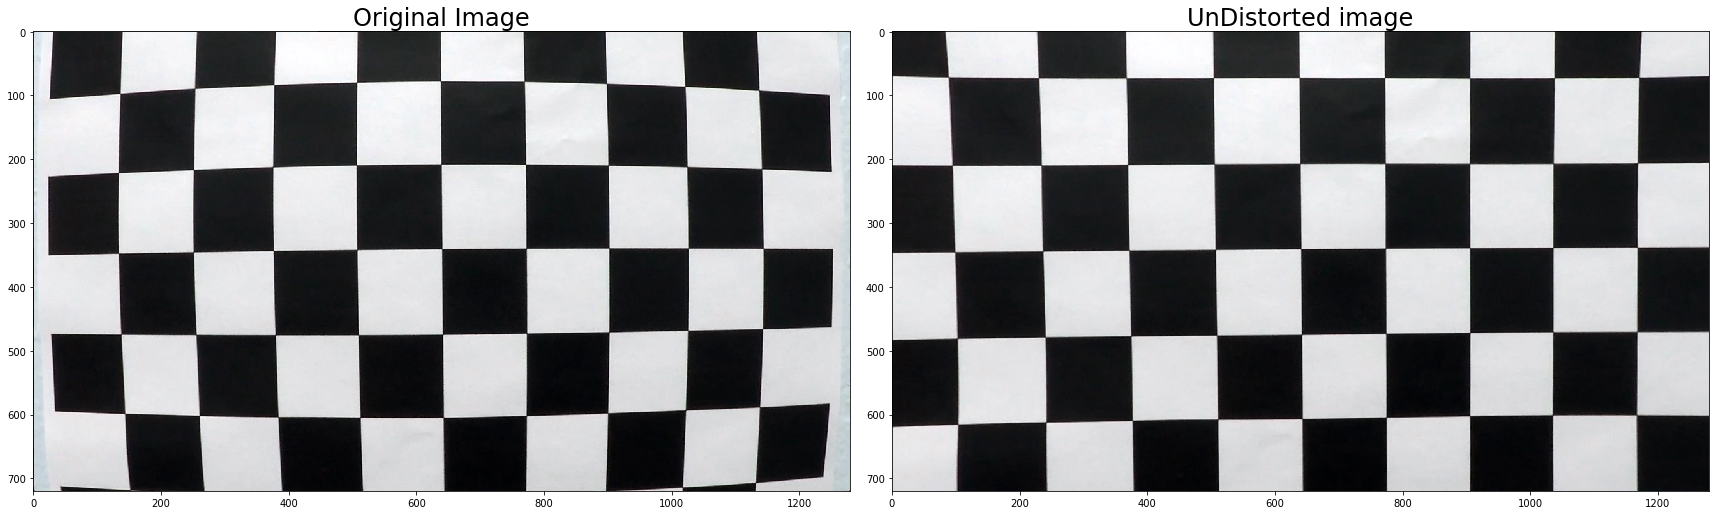

In [6]:
# Iterate over all the images in camera cal folder
images = glob.glob('./camera_cal/calibration*.jpg')
for idx,fname in enumerate(images):
#     print('Processing',fname)
    img = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
#         f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#         f.tight_layout()
#         ax1.imshow(img)
#         ax1.set_title('Original Image', fontsize=24)
        objpoints.append(objp)
        imgpoints.append(corners)
        
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         ax2.imshow(img)
#         ax2.set_title('Marked Image', fontsize=24)
        name = './camera_cal/camera_cal_marked/corner_marked'+str(idx)+'.jpg'
        cv2.imwrite(name,img)
#         plt.show()
        
# Loading image for referance and size
img_ref = cv2.imread('./camera_cal/calibration1.jpg')
ref_shape = (img_ref.shape[1],img_ref.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, ref_shape,None,None)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
# Save the pickle file
pickle.dump(dist_pickle, open( "calibration_pickle.p", "wb" ) )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_ref)
ax1.set_title('Original Image', fontsize=24)

img_ref = distort_fix_image(img_ref)
ax2.imshow(img_ref, cmap='gray')
ax2.set_title('UnDistorted image', fontsize=24)

plt.show()

In [5]:
def process_img(img):
    f, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=24)
    
    img = distort_fix_image(img)
    ax2.imshow(img, cmap='gray')
    ax2.set_title('UnDistorted image', fontsize=24)
    
    # Thresholding
    preprocessimage = process_image_thresholding(img)
    name = './test_images/test_images_preprocessimage/undistorted'+str(idx)+'.jpg'
    cv2.imwrite(name,preprocessimage)
    ax3.imshow(preprocessimage)
    ax3.set_title('Pre processed image', fontsize=24)

    img_size = (img.shape[1], img.shape[0]) # (1280, 720)

#     bot_width = .76 # % of bottom trapezoid height
#     mid_width = .08 # % of middle trapezoid height
#     height_pct = .62 # % of trapezoid height
#     bottom_trim = .935 # % from top to bottom

#     # source points
#     src = np.float32([[img.shape[1]*(.5-mid_width/2), img.shape[0]*height_pct], 
#                       [img.shape[1]*(.5+mid_width/2), img.shape[0]*height_pct],
#                      [img.shape[1]*(.5+bot_width/2), img.shape[0]*bottom_trim], 
#                       [img.shape[1]*(.5-bot_width/2), img.shape[0]*bottom_trim]])
#     offset = img_size[0]*.25
#     # destination points
#     dst = np.float32([[offset, 0], 
#                       [img_size[0]-offset, 0], 
#                       [img_size[0]-offset, img_size[1]], 
#                       [offset, img_size[1]]])

#     # Given src and dst points, calculate the perspective transform matrix
#     M = cv2.getPerspectiveTransform(src, dst)

    
    M, M_inv, warped = perspective_transform(img, preprocessimage)
#     # Warp the image using OpenCV warpPerspective()
#     warped = cv2.warpPerspective(preprocessimage, M, img_size,flags = cv2.INTER_LINEAR)
    name = './test_images/warpPerspective/undistorted'+str(idx)+'.jpg'
    cv2.imwrite(name,warped)
        
    ax4.imshow(warped, cmap='gray')
    ax4.set_title('perspective transformed', fontsize=24)


    # Tracker
    window_width = 80
    window_height = 160
    margin = 100
    curve_centers = tracker(window_width=window_width,window_height=window_height,margin=margin,ym = 10/720,xm = 4/384,smooth_factor = 50)
#     curve_centers = tracker(window_width=window_width,window_height=window_height,margin=margin,ym = 3./275,xm = 3.7/413,smooth_factor = 50)

    window_centroids = curve_centers.find_window_centroids(warped)
    leftx = []
    rightx = []
    # points to draw all left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    #drwaing the windows

    for level in range(0,len(window_centroids)):
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)

        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

        # add graphic points
        l_points[(l_points == 255)|(l_mask == 1)] = 255
        r_points[(r_points == 255)|(r_mask == 1)] = 255


    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    
    name = './test_images/test_images_preprocessimage1/undistorted'+str(idx)+'.jpg'
    cv2.imwrite(name,result)

    # Fit a second order polynomial to pixel positions in each fake lane line
    yvals = range(0,warped.shape[0])
#     yvals = np.linspace(0, window_height - 1, window_height)
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)

    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)

    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2),axis=0),
                                 np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2),axis=0),
                                 np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,right_fitx[::-1]-window_width/2),axis=0),
                                 np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road,[left_lane],color = [255,0,0])
    cv2.fillPoly(road,[right_lane],color = [0,0,255])
    cv2.fillPoly(road,[inner_lane],color = [0,255,0])
    cv2.fillPoly(road_bkg,[left_lane],color = [255,255,255])
    cv2.fillPoly(road_bkg,[left_lane],color = [255,255,255])

    road_warped = cv2.warpPerspective(road,M_inv,img_size,flags= cv2.INTER_LINEAR)
    name = './test_images/road_warped/undistorted'+str(idx)+'.jpg'
    cv2.imwrite(name,road_warped)
    road_warped_bkg = cv2.warpPerspective(road_bkg,M_inv,img_size,flags= cv2.INTER_LINEAR)

    base = cv2.addWeighted(img,1.0,road_warped_bkg,-1.0,0.0)
    result = cv2.addWeighted(base,1.0,road_warped,0.7,0.0)

    # calculate the offset of the car on road
    xm = curve_centers.xm_per_pix
    ym = curve_centers.ym_per_pix
    curve_fit_rad = np.polyfit(np.array(res_yvals,np.float32)*ym,np.array(leftx,np.float32)*xm,2)
    curverad = ((1+(2*curve_fit_rad[0]*yvals[-1]*ym + curve_fit_rad[1])**2)**1.5)/np.absolute(2*curve_fit_rad[0])
    camera_center = (left_fitx[-1]+right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    # show curvature,offset and speed
    cv2.putText(result,'Radius of curvature ='+str(round(curverad,3))+'(m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(result,'Vehicle is '+str(abs(round(center_diff,3)))+' m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

    name = './test_images/test_images_undistorted/undistorted'+str(idx)+'.jpg'
    cv2.imwrite(name,result)
    ax5.imshow(result, cmap='gray')
    ax5.set_title('final', fontsize=24)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    return result

./test_images/straight_lines1.jpg


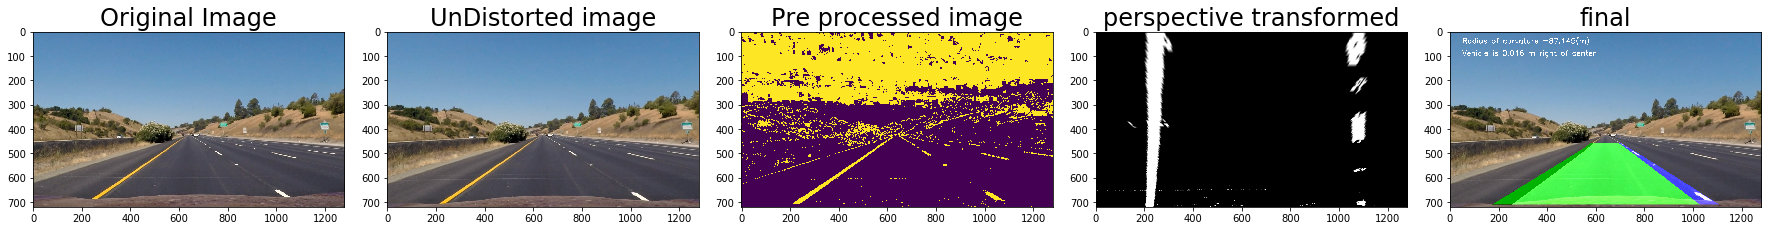

./test_images/straight_lines2.jpg


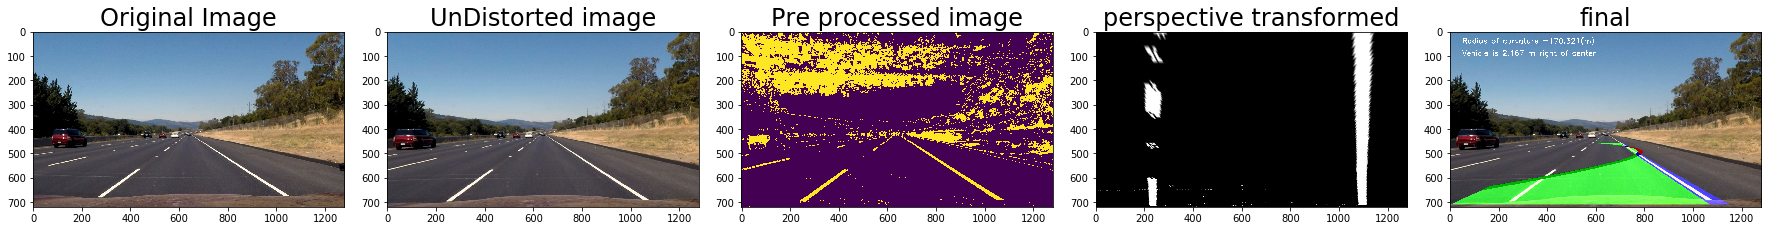

./test_images/test1.jpg


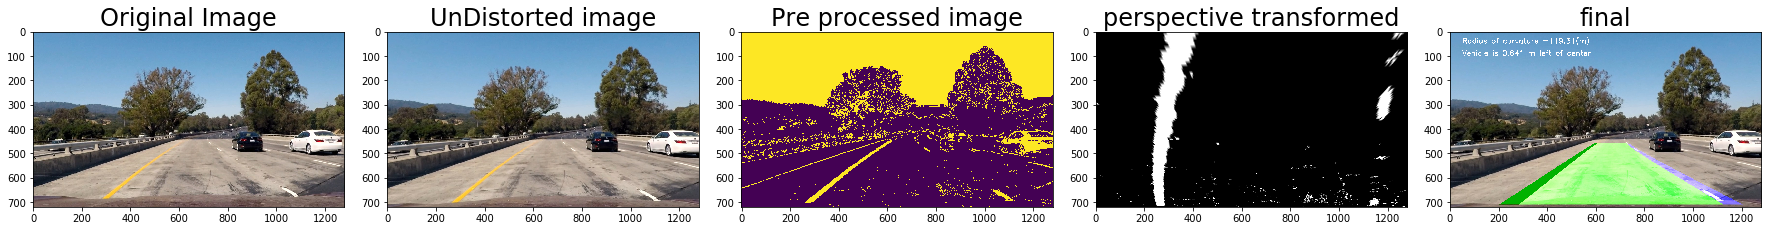

./test_images/test2.jpg


./test_images/test3.jpg


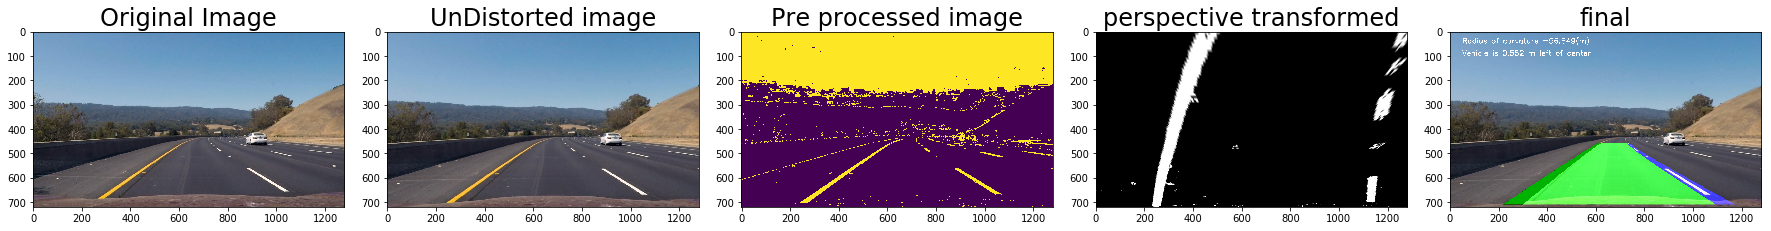

./test_images/test4.jpg


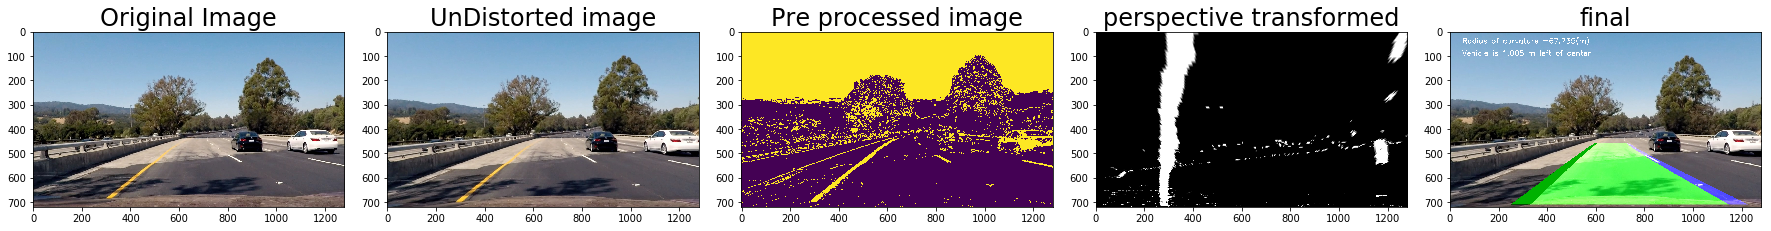

./test_images/test5.jpg


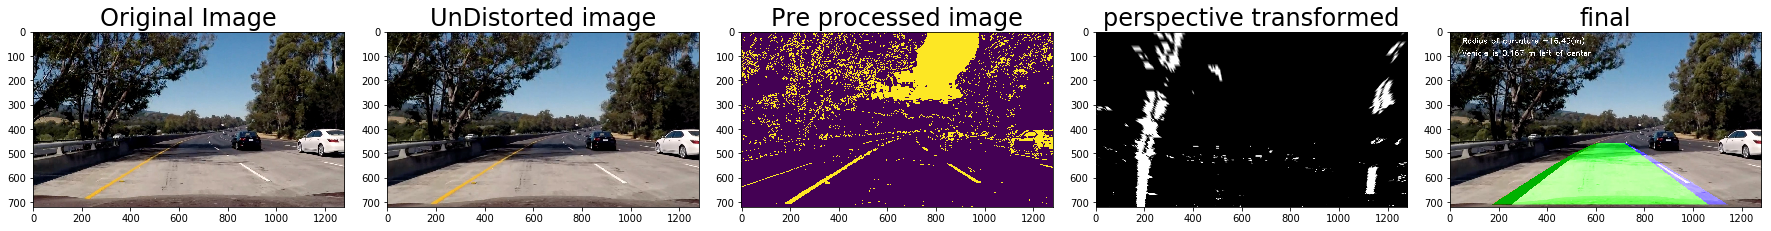

./test_images/test6.jpg


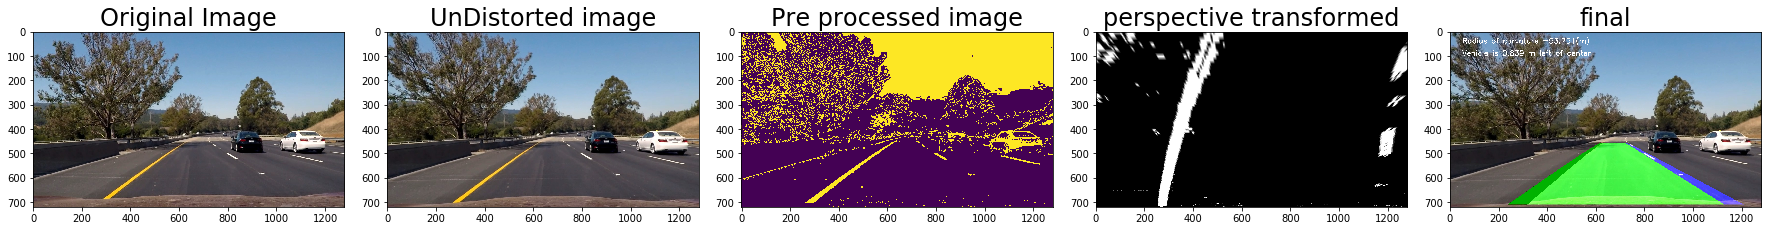

Done


In [6]:
dist_pickle = pickle.load( open( "calibration_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

images = glob.glob('./test_images/*.jpg')
for idx,fname in enumerate(images):
    print(fname)
    img = mpimg.imread(fname)
    result = process_img(img)
print('Done')

In [7]:
# # Video processing
# input_video = './project_video.mp4'
# output_video = 'output1_tracked.mp4'

# clip1 = VideoFileClip(input_video, audio = False)
# video_clip = clip1.fl_image(process_img)
# video_clip.write_videofile(output_video, audio = False)
# print('Done')

In [8]:

# input_video = './challenge_video.mp4'
# output_video = 'challenge_video_tracked.mp4'

# clip1 = VideoFileClip(input_video, audio = False)
# video_clip = clip1.fl_image(process_img)
# video_clip.write_videofile(output_video, audio = False)
# print('Done')


[[ 1280.   710.]
 [    0.   710.]
 [  546.   460.]
 [  732.   460.]] [[ 1280.   720.]
 [    0.   720.]
 [    0.     0.]
 [ 1280.     0.]]


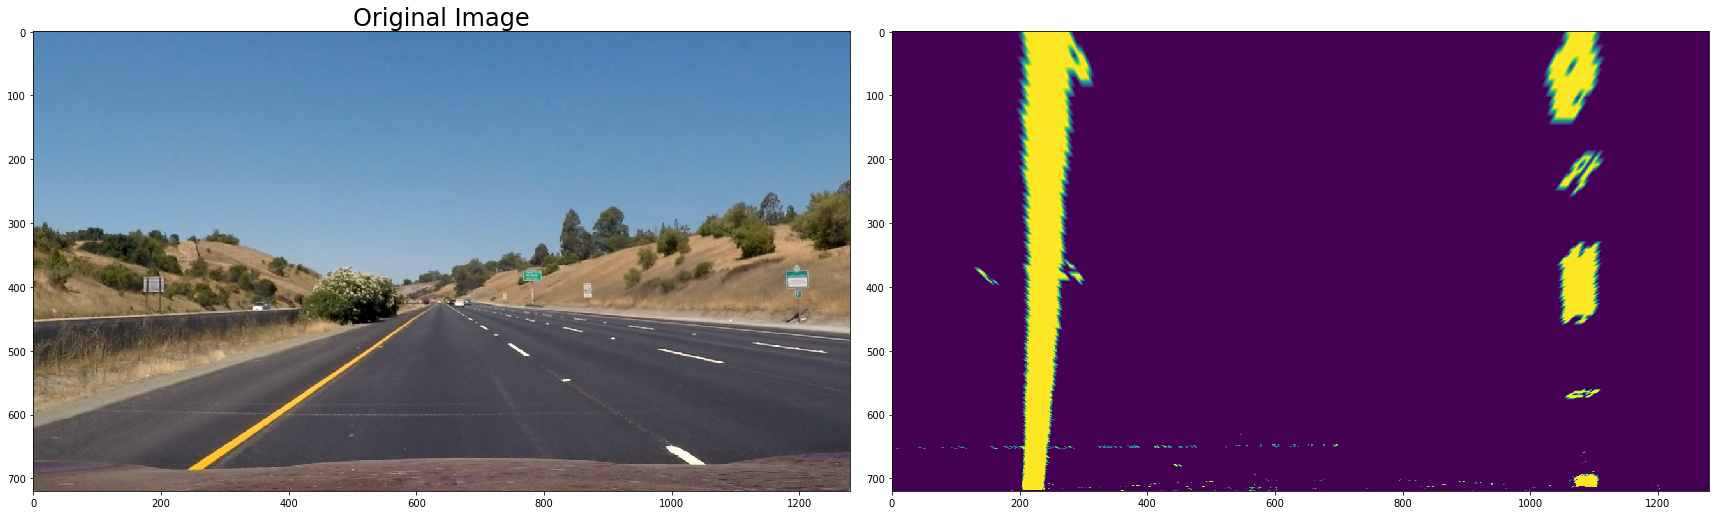

In [15]:

img = mpimg.imread('/Users/shubhama/Dropbox (Telenav)/SA - SDC Term-1/Udacity-SDC-ND-term-1/CarND-Advanced-Lane-Lines-P4/test_images/straight_lines1.jpg')


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=24)

img = distort_fix_image(img)

# Thresholding
preprocessimage = process_image_thresholding(img)

img_size = (img.shape[1], img.shape[0]) # (1280, 720)

#     bot_width = .76 # % of bottom trapezoid height
#     mid_width = .08 # % of middle trapezoid height
#     height_pct = .62 # % of trapezoid height
#     bottom_trim = .935 # % from top to bottom

#     # source points
#     src = np.float32([[img.shape[1]*(.5-mid_width/2), img.shape[0]*height_pct], 
#                       [img.shape[1]*(.5+mid_width/2), img.shape[0]*height_pct],
#                      [img.shape[1]*(.5+bot_width/2), img.shape[0]*bottom_trim], 
#                       [img.shape[1]*(.5-bot_width/2), img.shape[0]*bottom_trim]])
#     offset = img_size[0]*.25
#     # destination points
#     dst = np.float32([[offset, 0], 
#                       [img_size[0]-offset, 0], 
#                       [img_size[0]-offset, img_size[1]], 
#                       [offset, img_size[1]]])

#     # Given src and dst points, calculate the perspective transform matrix
#     M = cv2.getPerspectiveTransform(src, dst)


M, M_inv, warped = perspective_transform(img, preprocessimage)
#     # Warp the image using OpenCV warpPerspective()
#     warped = cv2.warpPerspective(preprocessimage, M, img_size,flags = cv2.INTER_LINEAR)
ax2.imshow(warped)
name = './examples/warped_straight_lines.jpg'
cv2.imwrite(name,warped)




# # Tracker
# window_width = 80
# window_height = 160
# margin = 100
# curve_centers = tracker(window_width=window_width,window_height=window_height,margin=margin,ym = 10/720,xm = 4/384,smooth_factor = 50)
# #     curve_centers = tracker(window_width=window_width,window_height=window_height,margin=margin,ym = 3./275,xm = 3.7/413,smooth_factor = 50)

# window_centroids = curve_centers.find_window_centroids(warped)
# leftx = []
# rightx = []
# # points to draw all left and right windows
# l_points = np.zeros_like(warped)
# r_points = np.zeros_like(warped)

# #drwaing the windows

# for level in range(0,len(window_centroids)):
#     l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
#     r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)

#     leftx.append(window_centroids[level][0])
#     rightx.append(window_centroids[level][1])

#     # add graphic points
#     l_points[(l_points == 255)|(l_mask == 1)] = 255
#     r_points[(r_points == 255)|(r_mask == 1)] = 255


# # Draw the results
# template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
# zero_channel = np.zeros_like(template) # create a zero color channle 
# template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
# warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
# result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

# name = './test_images/test_images_preprocessimage1/undistorted'+str(idx)+'.jpg'
# cv2.imwrite(name,result)

# # Fit a second order polynomial to pixel positions in each fake lane line
# yvals = range(0,warped.shape[0])
# #     yvals = np.linspace(0, window_height - 1, window_height)
# res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)

# left_fit = np.polyfit(res_yvals, leftx, 2)
# left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
# left_fitx = np.array(left_fitx,np.int32)

# right_fit = np.polyfit(res_yvals, rightx, 2)
# right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
# right_fitx = np.array(right_fitx,np.int32)

# left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2),axis=0),
#                              np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
# right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2),axis=0),
#                              np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
# inner_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,right_fitx[::-1]-window_width/2),axis=0),
#                              np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

# road = np.zeros_like(img)
# road_bkg = np.zeros_like(img)
# cv2.fillPoly(road,[left_lane],color = [255,0,0])
# cv2.fillPoly(road,[right_lane],color = [0,0,255])
# cv2.fillPoly(road,[inner_lane],color = [0,255,0])
# cv2.fillPoly(road_bkg,[left_lane],color = [255,255,255])
# cv2.fillPoly(road_bkg,[left_lane],color = [255,255,255])

# road_warped = cv2.warpPerspective(road,M_inv,img_size,flags= cv2.INTER_LINEAR)
# name = './test_images/road_warped/undistorted'+str(idx)+'.jpg'
# cv2.imwrite(name,road_warped)
# road_warped_bkg = cv2.warpPerspective(road_bkg,M_inv,img_size,flags= cv2.INTER_LINEAR)

# base = cv2.addWeighted(img,1.0,road_warped_bkg,-1.0,0.0)
# result = cv2.addWeighted(base,1.0,road_warped,0.7,0.0)

# # calculate the offset of the car on road
# xm = curve_centers.xm_per_pix
# ym = curve_centers.ym_per_pix
# curve_fit_rad = np.polyfit(np.array(res_yvals,np.float32)*ym,np.array(leftx,np.float32)*xm,2)
# curverad = ((1+(2*curve_fit_rad[0]*yvals[-1]*ym + curve_fit_rad[1])**2)**1.5)/np.absolute(2*curve_fit_rad[0])
# camera_center = (left_fitx[-1]+right_fitx[-1])/2
# center_diff = (camera_center-warped.shape[1]/2)*xm
# side_pos = 'left'
# if center_diff <= 0:
#     side_pos = 'right'

# # show curvature,offset and speed
# cv2.putText(result,'Radius of curvature ='+str(round(curverad,3))+'(m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
# cv2.putText(result,'Vehicle is '+str(abs(round(center_diff,3)))+' m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

# name = './test_images/test_images_undistorted/undistorted'+str(idx)+'.jpg'
# cv2.imwrite(name,result)
# ax5.imshow(result, cmap='gray')
# ax5.set_title('final', fontsize=24)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
# return result